In [1]:
import numpy as np
import pandas as pd
import catboost 
import os
from fastai2.tabular import *
from pathlib import Path
import shap
from catboost import CatBoostRegressor,Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## 数据预处理

In [2]:
path = Path('data/')
original_data = pd.read_excel(path/'F1_325.xlsx')
original_data.head(10)


Unnamed: 0         Unnamed: 1 注：原料性质、产品性质、待生吸附剂性质、再生吸附剂性质均不属于操作变量  \
0       样本编号                 时间                                原料性质   
1        NaN                NaN                            硫含量,μg/g   
2          1  2020/5/26 8:00:00                                 188   
3          2  2020/5/21 8:00:00                                 169   
4          3  2020/5/19 8:00:00                                 177   
5          4  2020/5/14 8:00:00                                 159   
6          5  2020/5/12 8:00:00                                 173   
7          6   2020/5/7 8:00:00                                 163   
8          7   2020/5/5 8:00:00                                 209   
9          8  2020/4/30 8:00:00                                 195   

  Unnamed: 3      Unnamed: 4 Unnamed: 5 Unnamed: 6     Unnamed: 7  \
0        NaN             NaN        NaN        NaN            NaN   
1     辛烷值RON  饱和烃,v%（烷烃+环烷烃）      烯烃,v%      芳烃,v%  溴值\n,gBr/100g   
2       90.6           53.23       24.4      22.37        61.4871   
3       90.5            52.3       26.4       21.3          61.88   
4       90.7            52.3    26.3143    21.3857        61.7229   
5       90.4            52.3       26.1       21.6          61.33   
6       89.6         52.2429    26.6714    21.0857        61.3329   
7         91            52.1       28.1       19.8          61.34   
8       90.4         51.3571    28.4143    20.2286          61.34   
9       90.5            49.5       29.2       21.3          61.34   

        Unnamed: 8 Unnamed: 9  ...               Unnamed: 360  \
0              NaN       产品性质  ...  S-ZORB.CAL_1.CANGLIANG.PV   
1  密度(20℃),\nkg/m³   硫含量,μg/g  ...                      再生器藏量   
2          726.086        3.2  ...                    2.04544   
3            731.3        3.2  ...                    2.02597   
4          729.614        3.2  ...                     1.9647   
5            725.4        3.2  ...                    2.03904   
6          725.429        3.2  ...                     1.9869   
7            725.5        3.2  ...                     1.9969   
8            725.5        4.6  ...                    1.95156   
9            725.5        6.6  ...                    1.99947   

             Unnamed: 361            Unnamed: 362  \
0  S-ZORB.FT_1006.DACA.PV  S-ZORB.FT_5204.DACA.PV   
1           加氢裂化轻石脑油进装置流量               汽油产品去气分流量   
2                 6368.75                 233.311   
3                 6360.65                 242.369   
4                 6504.96                 233.077   
5                 6506.82                  238.35   
6                 6560.24                 236.576   
7                 4995.82                 233.121   
8                 5013.53                 236.915   
9                 5085.55                 249.067   

                   Unnamed: 363                  Unnamed: 364  \
0  S-ZORB.FT_1006.TOTALIZERA.PV  S-ZORB.FT_5204.TOTALIZERA.PV   
1               加氢裂化轻石脑油进装置累积流量                   汽油产品去气分累积流量   
2                      83086802                        832504   
3                      82318954                        803463   
4                      82012004                        791925   
5                   8.12314e+07                        762864   
6                   8.09157e+07                        751362   
7                   8.01704e+07                        722436   
8                      79929377                        711181   
9                   7.93233e+07                        682186   

             Unnamed: 365                  Unnamed: 366  \
0  S-ZORB.FT_1503.DACA.PV  S-ZORB.FT_1503.TOTALIZERA.PV   
1       8.0MPa氢气至循环氢压缩机入口             8.0MPa氢气至循环氢压缩机入口   
2                 2216.41                   3.90631e+07   
3                 2370.59                   3.88106e+07   
4                 2326.47                      38693812   
5                 2495.22                   3.84109e+07   
6                 2807.79      

In [3]:
original_data.shape

(327, 370)

In [4]:
# 建立一个columns对应关系的dict
dictColumns = {}
for i in np.arange(370):
#     print(original_data.iloc[1,i])
    dictColumns[i] = original_data.iloc[1,i]

In [5]:
dictColumns[160],dictColumns[161]

('D-110蒸汽盘管入口流量', 'D-110底压力')

In [6]:
dictColumns

{0: nan,
 1: nan,
 2: '硫含量,μg/g',
 3: '辛烷值RON',
 4: '饱和烃,v%（烷烃+环烷烃）',
 5: '烯烃,v%',
 6: '芳烃,v%',
 7: '溴值\n,gBr/100g',
 8: '密度(20℃),\nkg/m³',
 9: '硫含量,μg/g',
 10: '辛烷值RON',
 11: 'RON损失\n（不是变量）',
 12: '焦炭,wt%',
 13: 'S, wt%',
 14: '焦炭,wt%',
 15: 'S, wt%',
 16: '氢油比',
 17: '反应过滤器压差',
 18: '还原器压力',
 19: '还原器流化氢气流量',
 20: '反应器上部温度',
 21: '反应器底部温度',
 22: '反应器顶部压力',
 23: '反应器顶底压差',
 24: '反应过滤器压差',
 25: '反吹氢气温度',
 26: 'D105温度',
 27: 'D105压力',
 28: 'D105流化氢气流量',
 29: '反吹氢气压力',
 30: '稳定塔顶压力',
 31: '稳定塔下部温度',
 32: '稳定塔液位',
 33: '塔顶回流罐D201液位',
 34: '干气出装置温度',
 35: '精制汽油出装置温度',
 36: '精制汽油出装置流量',
 37: '精制汽油出装置硫含量',
 38: '蒸汽进装置压力',
 39: '蒸汽进装置流量',
 40: '新氢进装置流量',
 41: '轻烃出装置流量',
 42: '干气出装置流量',
 43: '污油出装置',
 44: '燃料气进装置温度',
 45: '燃料气进装置压力',
 46: '燃料气进装置流量',
 47: '氮气进装置流量',
 48: '氮气进装置压力',
 49: '1.0MPa蒸汽进装置温度',
 50: '循环水进装置流量',
 51: '循环水出装置流量 ',
 52: '0.3MPa凝结水出装置流量',
 53: '除氧水进装置流量',
 54: '非净化风进装置流量',
 55: '非净化风进装置压力',
 56: '净化风进装置流量',
 57: '净化风进装置压力',
 58: 'D107转剂线压差',
 59: 'D107提升氮气流量',
 60: '催化汽油进

In [7]:
# 删除没有用的行与列
original_data.drop(['Unnamed: 0', 'Unnamed: 1'],inplace=True,axis=1)
original_data.drop([0,1],inplace=True)
# 对column重新进行编号与赋值
columnames = list(range(368))
original_data.columns = columnames

In [8]:
original_data.head(5)

0     1        2        3        4        5        6    7      8     9    \
2  188  90.6    53.23     24.4    22.37  61.4871  726.086  3.2  89.22  1.38   
3  169  90.5     52.3     26.4     21.3    61.88    731.3  3.2  89.32  1.18   
4  177  90.7     52.3  26.3143  21.3857  61.7229  729.614  3.2  89.32  1.38   
5  159  90.4     52.3     26.1     21.6    61.33    725.4  3.2  89.02  1.38   
6  173  89.6  52.2429  26.6714  21.0857  61.3329  725.429  3.2  88.32  1.28   

   ...      358      359      360          361     362      363          364  \
2  ...  2.04544  6368.75  233.311     83086802  832504  2216.41  3.90631e+07   
3  ...  2.02597  6360.65  242.369     82318954  803463  2370.59  3.88106e+07   
4  ...   1.9647  6504.96  233.077     82012004  791925  2326.47     38693812   
5  ...  2.03904  6506.82   238.35  8.12314e+07  762864  2495.22  3.84109e+07   
6  ...   1.9869  6560.24  236.576  8.09157e+07  751362  2807.79     38283000   

       365          366       367  
2  1840.14     39608757  0.353271  
3  1641.73     39389299  0.354504  
4  1600.68  3.93126e+07  0.350181  
5  1563.71  3.91202e+07   0.35393  
6  1554.36   3.9046e+07  0.358053  

[5 rows x 368 columns]

In [9]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 2 to 326
Columns: 368 entries, 0 to 367
dtypes: object(368)
memory usage: 936.9+ KB


In [10]:
original_data[9]

2      1.38
3      1.18
4      1.38
5      1.38
6      1.28
       ... 
322    1.15
323    1.25
324    1.35
325    1.28
326    1.25
Name: 9, Length: 325, dtype: object

In [11]:
original_data.head(3)

0     1      2        3        4        5        6    7      8     9    \
2  188  90.6  53.23     24.4    22.37  61.4871  726.086  3.2  89.22  1.38   
3  169  90.5   52.3     26.4     21.3    61.88    731.3  3.2  89.32  1.18   
4  177  90.7   52.3  26.3143  21.3857  61.7229  729.614  3.2  89.32  1.38   

   ...      358      359      360       361     362      363          364  \
2  ...  2.04544  6368.75  233.311  83086802  832504  2216.41  3.90631e+07   
3  ...  2.02597  6360.65  242.369  82318954  803463  2370.59  3.88106e+07   
4  ...   1.9647  6504.96  233.077  82012004  791925  2326.47     38693812   

       365          366       367  
2  1840.14     39608757  0.353271  
3  1641.73     39389299  0.354504  
4  1600.68  3.93126e+07  0.350181  

[3 rows x 368 columns]

In [12]:
original_data.reset_index(drop=True,inplace=True)

In [13]:
original_data

0     1        2        3        4        5        6     7      8    \
0        188  90.6    53.23     24.4    22.37  61.4871  726.086   3.2  89.22   
1        169  90.5     52.3     26.4     21.3    61.88    731.3   3.2  89.32   
2        177  90.7     52.3  26.3143  21.3857  61.7229  729.614   3.2  89.32   
3        159  90.4     52.3     26.1     21.6    61.33    725.4   3.2  89.02   
4        173  89.6  52.2429  26.6714  21.0857  61.3329  725.429   3.2  88.32   
..       ...   ...      ...      ...      ...      ...      ...   ...    ...   
320  271.429  89.2    47.19     31.3    21.51    52.02    725.2   3.2  88.05   
321  271.429  89.2    47.19     31.3    21.51    52.02    725.2   3.2  87.95   
322  271.429  89.4    47.19     31.3    21.51    52.02    725.2   3.2  88.05   
323      266  89.4    46.72    33.78     19.5    45.45      730   3.6  88.12   
324      266  89.9    46.72    33.78     19.5    45.45      730  11.8  88.65   

      9    ...      358      359      360          361          362  \
0    1.38  ...  2.04544  6368.75  233.311     83086802       832504   
1    1.18  ...  2.02597  6360.65  242.369     82318954       803463   
2    1.38  ...   1.9647  6504.96  233.077     82012004       791925   
3    1.38  ...  2.03904  6506.82   238.35  8.12314e+07       762864   
4    1.28  ...   1.9869  6560.24  236.576  8.09157e+07       751362   
..    ...  ...      ...      ...      ...          ...          ...   
320  1.15  ...  3.45457  8328.97  150.442  8.40875e+07  2.13669e+06   
321  1.25  ...  2.75257  8457.86  148.748  8.36871e+07  2.12927e+06   
322  1.35  ...  2.93576  8246.21  150.095  8.30876e+07  2.11847e+06   
323  1.28  ...  3.17403   7998.8  149.534  8.26961e+07  2.11096e+06   
324  1.25  ...  2.64258  8379.94  158.409  8.23066e+07  2.10337e+06   

             363          364      365          366       367  
0        2216.41  3.90631e+07  1840.14     39608757  0.353271  
1        2370.59  3.88106e+07  1641.73     39389299  0.354504  
2        2326.47     38693812  1600.68  3.93126e+07  0.350181  
3        2495.22  3.84109e+07  1563.71  3.91202e+07   0.35393  
4        2807.79     38283000  1554.36   3.9046e+07  0.358053  
..           ...          ...      ...          ...       ...  
320  3.15996e+06   1.5695e+06 -7028.12  1.00328e+06  -118.251  
321      3662122  1.52126e+06  -8555.3       879437  -118.764  
322  4.41537e+06   1.4489e+06 -10846.1       693677  -119.534  
323  4.91754e+06  1.40066e+06 -12373.3       569837  -120.047  
324      5419704  1.35242e+06 -13900.5       445997   -120.56  

[325 rows x 368 columns]

In [14]:
original_data.dtypes

0      object
1      object
2      object
3      object
4      object
        ...  
363    object
364    object
365    object
366    object
367    object
Length: 368, dtype: object

In [15]:
for i in range(368):
    original_data[i]=original_data[i].astype('float')

In [16]:
original_data.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
363    float64
364    float64
365    float64
366    float64
367    float64
Length: 368, dtype: object

In [17]:
#  把目标值单独拎出来
#  ronTarget, sTarget,deltaRonTarget 
ronTarget = original_data.iloc[:,8]
ronTarget
sTarget = original_data.iloc[:,7]
sTarget
deltaRonTarget = original_data.iloc[:,9]
deltaRonTarget

0      89.22
1      89.32
2      89.32
3      89.02
4      88.32
       ...  
320    88.05
321    87.95
322    88.05
323    88.12
324    88.65
Name: 8, Length: 325, dtype: float64

0       3.2
1       3.2
2       3.2
3       3.2
4       3.2
       ... 
320     3.2
321     3.2
322     3.2
323     3.6
324    11.8
Name: 7, Length: 325, dtype: float64

0      1.38
1      1.18
2      1.38
3      1.38
4      1.28
       ... 
320    1.15
321    1.25
322    1.35
323    1.28
324    1.25
Name: 9, Length: 325, dtype: float64

## 特征工程

In [18]:
shap.initjs()

In [19]:
original_data.head()

0     1          2          3          4          5           6    7    \
0  188.0  90.6  53.230000  24.400000  22.370000  61.487143  726.085714  3.2   
1  169.0  90.5  52.300000  26.400000  21.300000  61.880000  731.300000  3.2   
2  177.0  90.7  52.300000  26.314286  21.385714  61.722857  729.614286  3.2   
3  159.0  90.4  52.300000  26.100000  21.600000  61.330000  725.400000  3.2   
4  173.0  89.6  52.242857  26.671429  21.085714  61.332857  725.428571  3.2   

     8     9    ...       358         359         360         361         362  \
0  89.22  1.38  ...  2.045436  6368.74700  233.310805  83086802.0  832503.795   
1  89.32  1.18  ...  2.025974  6360.64530  242.369205  82318954.0  803462.665   
2  89.32  1.38  ...  1.964696  6504.96490  233.076925  82012004.0  791925.055   
3  89.02  1.38  ...  2.039041  6506.82495  238.349935  81231373.5  762863.810   
4  88.32  1.28  ...  1.986900  6560.24225  236.576220  80915707.5  751362.300   

          363         364         365         366       367  
0  2216.40935  39063124.5  1840.14470  39608757.0  0.353271  
1  2370.58740  38810581.5  1641.73260  39389299.0  0.354504  
2  2326.46535  38693812.0  1600.67575  39312616.5  0.350181  
3  2495.22360  38410862.5  1563.71215  39120204.5  0.353930  
4  2807.78910  38283000.0  1554.35740  39045953.5  0.358053  

[5 rows x 368 columns]

In [25]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Columns: 368 entries, 0 to 367
dtypes: float64(368)
memory usage: 934.5 KB


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5842668	test: 1.2575209	best: 1.2575209 (0)	total: 93.3ms	remaining: 4.57s
49:	learn: 0.7206537	test: 1.1722028	best: 1.1557755 (39)	total: 3.86s	remaining: 0us
bestTest = 1.155775478
bestIteration = 39
Shrink model to first 40 iterations.


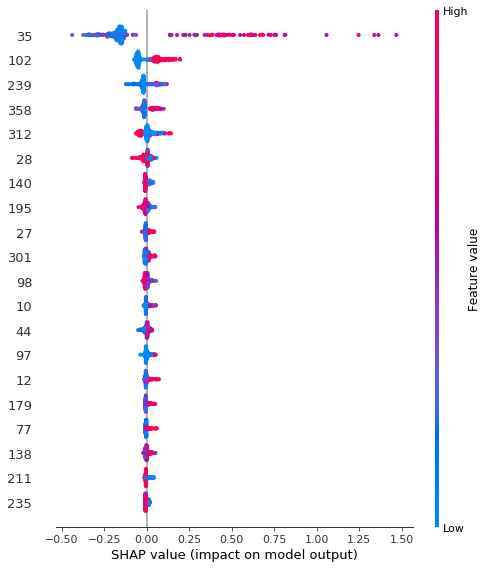

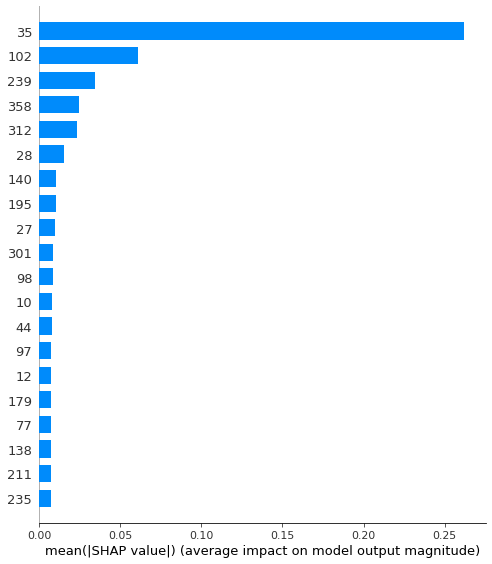

In [38]:
def getCatModel(targetName):
    # To get the catboost model 
    # drop the target from the original data
    if str(targetName) == 'ron':
        target = original_data.iloc[:,8]
        temp = original_data.drop(columns=[8])
#         target = temp.pop(8)([])
    elif str(targetName)=='s':
        target = original_data.iloc[:,7]
        temp = original_data.drop(columns=[7])
    elif str(targetName)=='delta':
        #         target = temp.pop(9)
        target = original_data.iloc[:,9]
        temp = original_data.drop(columns=[9])


    # split the dataset
    X_train, X_validation, y_train, y_validation = train_test_split(temp, target, train_size=0.8, random_state=42)
    X_train.shape, X_validation.shape, y_train.shape, y_validation.shape
    # Catboost
    # construct the right model to select the best parameter
    model = CatBoostRegressor(n_estimators=50,
                              max_depth=11,
                              loss_function='RMSE',
                              eval_metric='RMSE',
                              task_type='GPU',
                              learning_rate=0.05,
                              boosting_type='Plain',
                              bootstrap_type='Bernoulli',
                              subsample=0.85,
                              silent=True)
    model.fit(X_train,
              y_train,
              verbose_eval=100,
              early_stopping_rounds=50,
              eval_set=(X_validation, y_validation),
              use_best_model=True,
              plot=True)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(Pool(X_train,y_train))
#     shap_values = explainer.shap_values(original_data.iloc[:350,:])
    shap_values[:35]
    shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_train.iloc[:1000,:])

#     shap.summary_plot(shap_values,original_data.iloc[:350,:])
    shap.summary_plot(shap_values,X_train.iloc[:350,:])
    shap.summary_plot(shap_values,X_train,plot_type='bar')
#     explainer.expected_value
#     shap.summary_plot(shap_values,original_data,plot_type='bar')
    return explainer,shap_values,X_train


explainer,shap_values,X_train = getCatModel('s')
    

In [29]:
dictColumns[9]

'硫含量,μg/g'

In [39]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_train.iloc[:1000,:])
